In [7]:
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
%matplotlib inline

# Extract data
This code extracts the throughput data from the log file

In [11]:
def get_results(path):
    statistic = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("[Epoch] ")):
                statistic.append(line.strip("[Epoch] ").strip("\n").split(","))

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=float)
    
    # print(statistic)
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """
    time_epoch = 1
    max_n_rows = 0
    for i in range(20):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_n_rows):
            max_n_rows = th[0]

    # print("max runtime = ", max_n_rows,)
    

    results_padding = np.zeros(max_n_rows)
    
    for i in range(20):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = last_done
        cur_length = cur_done.shape[0]
        # print(cur_length, i)
        padding = np.pad(eopch, (0, max_n_rows-cur_length), 'constant', constant_values=(0,0))
        results_padding += padding
    through_x = results_padding[:max_n_rows]/time_epoch/1024/1024
    time_x = np.array([i for i in np.arange(time_epoch, (max_n_rows + 1)*time_epoch, time_epoch)])
    # print (results_padding)
    # print (through_x)
    # print (time_x)
    return time_x, through_x

In [12]:
def first_index_above_threshold(throughput, top):
    # Find the maximum throughput and calculate 90% of it
    max_throughput = np.max(throughput)
    threshold = max_throughput * 0.9

    # Find the first index where the throughput crosses the 90% threshold
    index = np.argmax(throughput >= threshold)
    return index

# Startup time for cold start OOM
- key size: uint64_t
- value size: 512 bytes
- num of keys in dataset: 200M
- dram size: 50 G
- dataset size: 194 G

In [7]:
exp1 = "../logs/coldstartleanstore.log"
exp2 = "../logs/coldstartlearnstore.log"

In [42]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)

/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

In [43]:
t1_index = first_index_above_threshold(through_1, 0.9)
t2_index = first_index_above_threshold(through_2, 0.9)
time1_90 = time_1[t1_index]
time2_90 = time_2[t2_index]

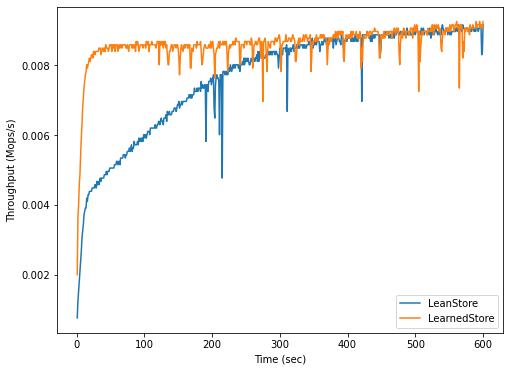

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="LearnedStore")
# ax.axvline(x=time1_90, color="red", linestyle="--")
# ax.axvline(x=time2_90, color="green", linestyle="--")
# ax.text(time1_90+10, 0.001, f'leanstore time to achive 90% of max throughput {time1_90:d}s', rotation=90, fontsize=10)
# ax.text(time2_90+10, 0.001, f'leanstore time to achive 90% of max throughput {time2_90:d}s', rotation=90, fontsize=10)
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="lower right")
# ax.set_title("LeanStore vs LearnStore startup time")
plt.savefig("../logs/throughput_startup_cold_oom.png")

# Result
|Approach | 90% of max throughput | 
|--------- | --------------------- |
| LeanStore | 266 |
| LearnedStore | 25 |
| Improvement | 10.64 times |

# Startup time for hot start inmemory
- key size: uint64_t
- value size: 512 bytes
- num of keys in dataset: 10M
- dram size: 100 G
- dataset size: 194 G

In [45]:
exp1 = "../logs/in_mem_hotread.log"
exp2 = "../logs/in_mem_hotreadseg.log"

In [46]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)

/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

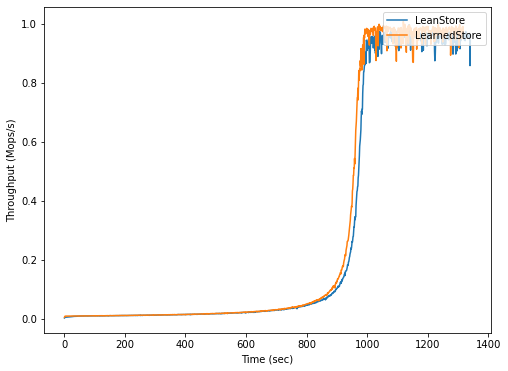

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="LearnedStore")
# ax.axvline(x=time1_90, color="red", linestyle="--")
# ax.axvline(x=time2_90, color="green", linestyle="--")
# ax.text(time1_90+10, 0.001, f'leanstore time to achive 90% of max throughput {time1_90:d}s', rotation=90, fontsize=10)
# ax.text(time2_90+10, 0.001, f'leanstore time to achive 90% of max throughput {time2_90:d}s', rotation=90, fontsize=10)
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")
# ax.set_title("LeanStore vs LearnedStore startup time")
plt.savefig("../logs/throughput_startup_hot.png")

# Startup time for cold start inmemory
- key size: uint64_t
- value size: 512 bytes
- num of keys in dataset: 10M
- dram size: 100 G
- dataset size: 194 G

In [50]:
exp1 = "../logs/in_mem_coldread.log"
exp2 = "../logs/in_mem_coldreadseg.log"

In [51]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)

/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

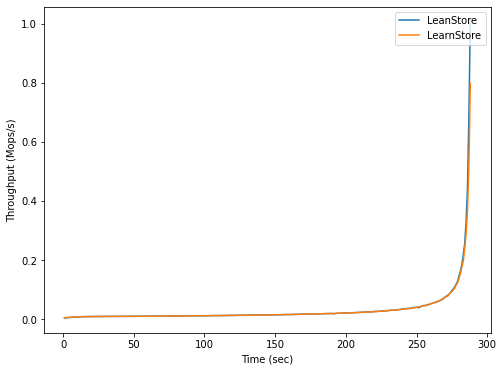

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="LearnStore")
# ax.axvline(x=time1_90, color="red", linestyle="--")
# ax.axvline(x=time2_90, color="green", linestyle="--")
# ax.text(time1_90+10, 0.001, f'leanstore time to achive 90% of max throughput {time1_90:d}s', rotation=90, fontsize=10)
# ax.text(time2_90+10, 0.001, f'leanstore time to achive 90% of max throughput {time2_90:d}s', rotation=90, fontsize=10)
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")
# ax.set_title("LeanStore vs LearnStore startup time")
plt.savefig("../logs/throughput_startup_cold.png")

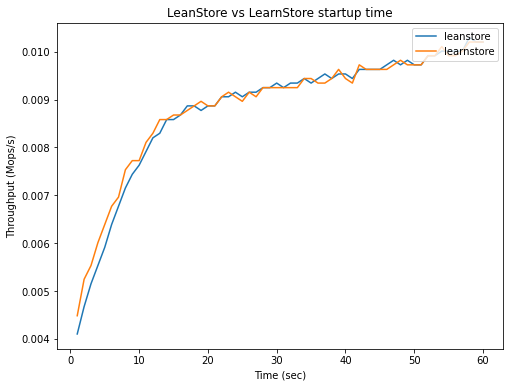

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1[:60], through_1[:60], label="leanstore")
ax.plot(time_2[:60], through_2[:60], label="learnstore")
# ax.axvline(x=time1_90, color="red", linestyle="--")
# ax.axvline(x=time2_90, color="green", linestyle="--")
# ax.text(time1_90+10, 0.001, f'leanstore time to achive 90% of max throughput {time1_90:d}s', rotation=90, fontsize=10)
# ax.text(time2_90+10, 0.001, f'leanstore time to achive 90% of max throughput {time2_90:d}s', rotation=90, fontsize=10)
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")
ax.set_title("LeanStore vs LearnStore startup time")
plt.savefig("../logs/throughput_startup_cold.png")

# Throughput when a layer of inner node is on disk
- key size: uint64_t
- value size: 512 bytes
- num of keys in dataset: 200M
- dram size: 1 G
- dataset size: 194 G
- SSD type: SATA

In [8]:
# exp1 = "../logs/200M_small_dram_1.log"
# exp2 = "../logs/200M_small_dram_learnstore_1.log"
exp1 = "../logs/200M_512b_read.log"
exp2 = "../logs/200M_512b_readseg.log"

In [9]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)
nsecs = 150
print(f"Max LeanStore: {max(through_1)} LearnedStore: {max(through_2)}")

Max LeanStore: 0.004863739013671875 LearnedStore: 0.008487701416015625


/tmp/ipykernel_1638955/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1638955/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

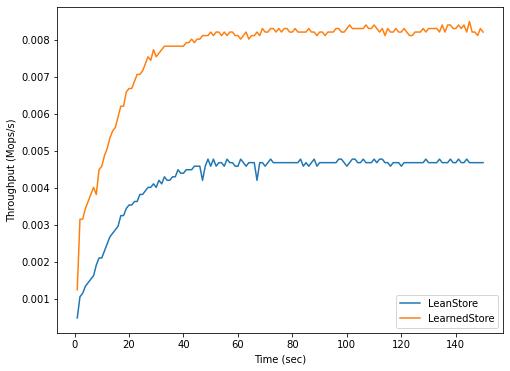

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1[:nsecs], through_1[:nsecs], label="LeanStore")
ax.plot(time_2[:nsecs], through_2[:nsecs], label="LearnedStore")
# ax.axvline(x=time1_90, color="red", linestyle="--")
# ax.axvline(x=time2_90, color="green", linestyle="--")
# ax.text(time1_90+10, 0.001, f'leanstore time to achive 90% of max throughput {time1_90:d}s', rotation=90, fontsize=10)
# ax.text(time2_90+10, 0.001, f'leanstore time to achive 90% of max throughput {time2_90:d}s', rotation=90, fontsize=10)
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="lower right")
#ax.set_title("LeanStore vs LearnStore throughput vs time")
plt.savefig("../logs/throughput_sata.png")

# Throughput when a layer of inner node is on disk
- key size: uint64_t
- value size: 512 bytes
- num of keys in dataset: 200M
- dram size: 1 G
- dataset size: 194 G
- SSD type: NVME

In [23]:
exp1 = "../logs/200M_small_dram_leanstore_1_nvme.log"
exp2 = "../logs/200M_small_dram_learnstore_1_nvme.log"

In [57]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)
nsecs = 150
print(f"Max LeanStore: {max(through_1)} LearnedStore: {max(through_2)}")

Max LeanStore: 0.004863739013671875 LearnedStore: 0.00858306884765625


/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

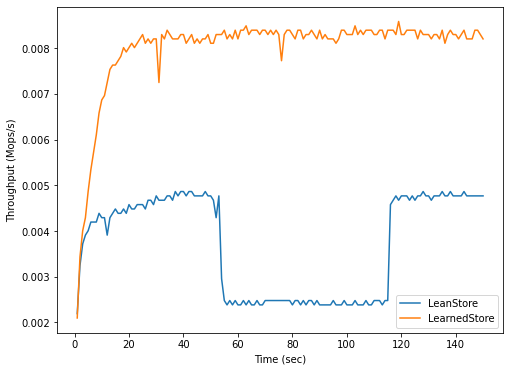

In [58]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1[:nsecs], through_1[:nsecs], label="LeanStore")
ax.plot(time_2[:nsecs], through_2[:nsecs], label="LearnedStore")
# ax.axvline(x=time1_90, color="red", linestyle="--")
# ax.axvline(x=time2_90, color="green", linestyle="--")
# ax.text(time1_90+10, 0.001, f'leanstore time to achive 90% of max throughput {time1_90:d}s', rotation=90, fontsize=10)
# ax.text(time2_90+10, 0.001, f'leanstore time to achive 90% of max throughput {time2_90:d}s', rotation=90, fontsize=10)
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="lower right")
# ax.set_title("LeanStore vs LearnStore throughput vs time")
plt.savefig("../logs/throughput_nvme.png")

# Result
| Type | LeanStore | LearnStore | Improvement |
|------| --------- | ---------- | ----------- |
| SATA | 0.0049591064453125 | 0.00858306884765625 | 1.73 |
| NVME | 0.00591278076171875 | 0.0102996826171875 | 1.74 | 

# Inmem cold start

In [59]:
exp1 = "../logs/in_mem_hotread.log"
exp2 = "../logs/in_mem_hotreadseg.log"

In [60]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)

/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

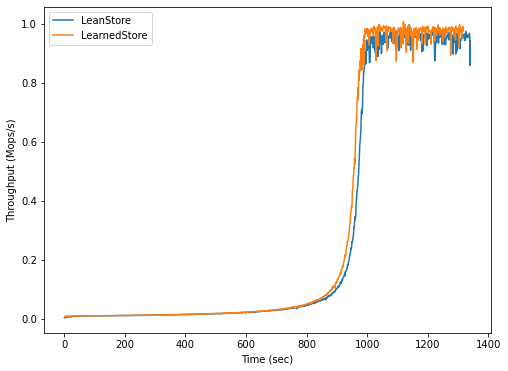

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="LearnedStore")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper left")
plt.savefig("../logs/throughput_inmem_hot.png")

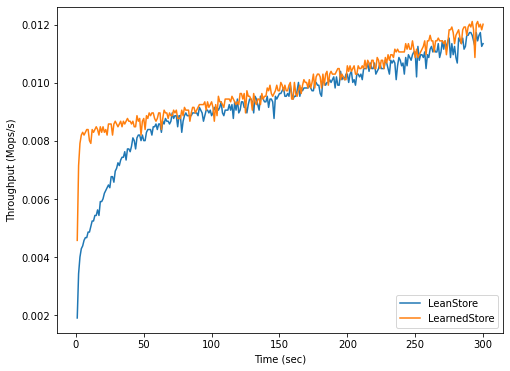

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))
nsecs = 300
ax.plot(time_1[:nsecs], through_1[:nsecs], label="LeanStore")
ax.plot(time_2[:nsecs], through_2[:nsecs], label="LearnedStore")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="lower right")
plt.savefig("../logs/throughput_inmem_startup_zoom.png")

# Insert throughput while using seg


In [68]:
exp1 = "/tmp/load.log"
exp2 = "/tmp/load_fast.log"

In [69]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)

/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

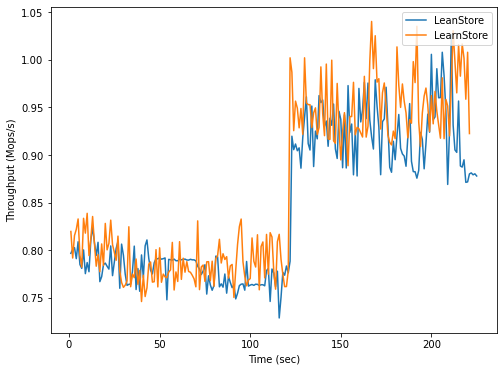

In [70]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="LearnStore")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")

# Effect of insert
- load
- train
- read
- load
- read

In [71]:
exp1 = "/tmp/readafterinsertorg_linear.log"
exp2 = "/tmp/readafterinsertseg_linear.log"
exp3 = "/tmp/readafterinsertrs_linear.log"

In [34]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)
time_3, through_3 = get_results(exp3)

/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

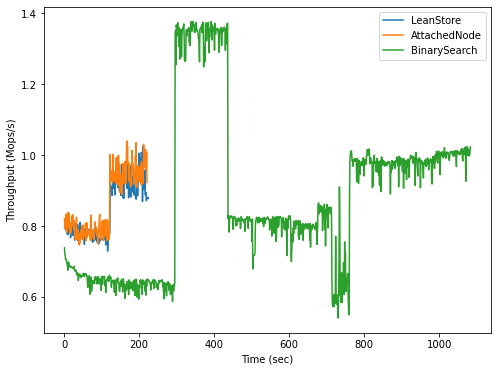

In [72]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="AttachedNode")
ax.plot(time_3, through_3, label="BinarySearch")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")
plt.savefig("../logs/throughput_readafterinsert_linear.png")

In [74]:
exp1 = "/tmp/readafterinsertorg_books.log"
exp2 = "/tmp/readafterinsertseg_books.log"
exp3 = "/tmp/readafterinsertrs_books.log"

In [75]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)
time_3, through_3 = get_results(exp3)

/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1930950/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

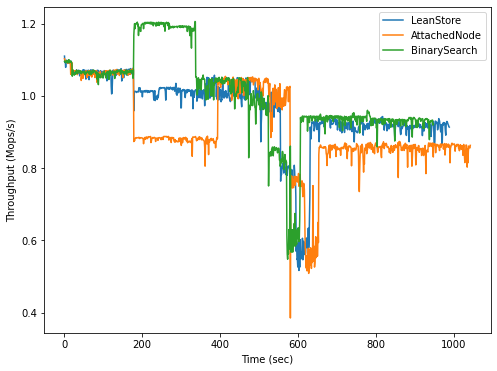

In [77]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="AttachedNode")
ax.plot(time_3, through_3, label="BinarySearch")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")
plt.savefig("../logs/throughput_readafterinsert_books.png")

In [6]:
# Cold start throughput
exp1 = "../logs/at_root_hotread.log"
exp2 = "../logs/at_root_hotreadseg.log"

In [7]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)

/tmp/ipykernel_960485/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_960485/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread'

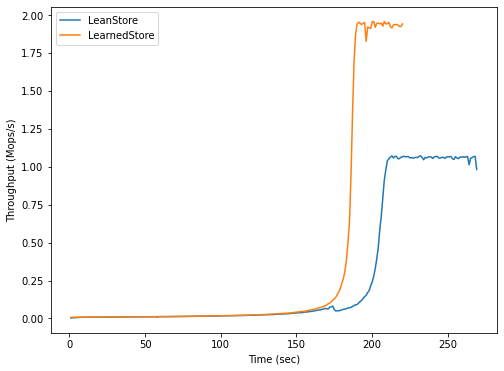

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="LearnedStore")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper left")
plt.savefig("../logs/throughput_atroot_hot.png")

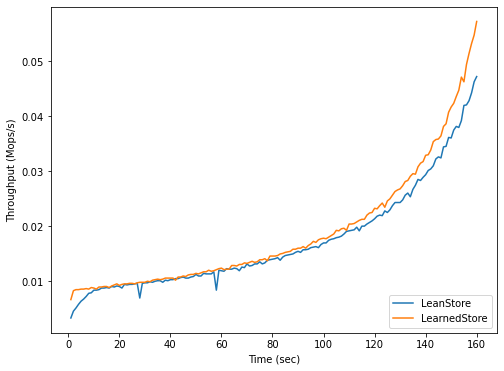

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
nsecs = 160
ax.plot(time_1[:nsecs], through_1[:nsecs], label="LeanStore")
ax.plot(time_2[:nsecs], through_2[:nsecs], label="LearnedStore")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="lower right")
plt.savefig("../logs/throughput_inmem_startup_zoom.png")

# Fast Insert

In [9]:
exp1 = "../logs/two_insert.log"
exp2 = "../logs/two_insert_fast.log"

In [10]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)

/tmp/ipykernel_1005354/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1005354/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

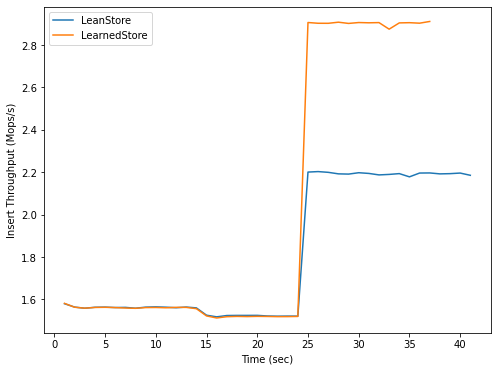

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="LearnedStore")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Insert Throughput (Mops/s)")
ax.legend(loc="upper left")
fig.savefig("../logs/two_insert_seqwrite.png")

In [15]:
exp1 = "../logs/two_insert_ranorder.log"
exp2 = "../logs/two_insert_fast_ranorder.log"

In [16]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)

/tmp/ipykernel_1005354/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1005354/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

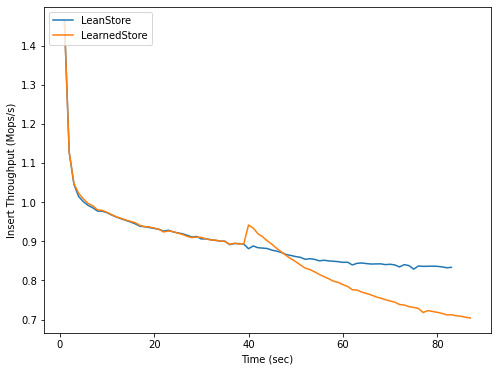

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="LearnedStore")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Insert Throughput (Mops/s)")
ax.legend(loc="upper left")
fig.savefig("../logs/two_insert_ranwrite.png")

# First Sequential load 

In [6]:
exp1 = "../logs/two_insert_firstsortedorder.log"
exp2 = "../logs/two_insertfast_firstsortedorder.log"

In [7]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)

/tmp/ipykernel_1088804/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1088804/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

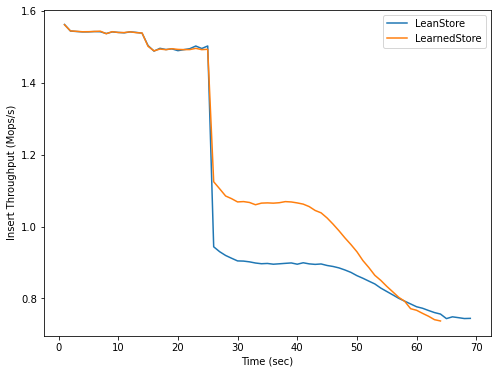

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="LearnedStore")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Insert Throughput (Mops/s)")
ax.legend(loc="upper right")
fig.savefig("../logs/two_insert_firstsortedorder.png")

# YCSBA

In [12]:
exp_1 = "../logs/ycsba.log"
exp_2 = "../logs/ycsbaseg.log"
exp_3 = "../logs/ycsbaseg_fastinsert.log"

In [13]:
time_1, through_1 = get_results(exp_1)
time_2, through_2 = get_results(exp_2)
time_3, through_3 = get_results(exp_3)

/tmp/ipykernel_1088804/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1088804/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

Text(0, 0.5, 'Throughput (Mops/s)')

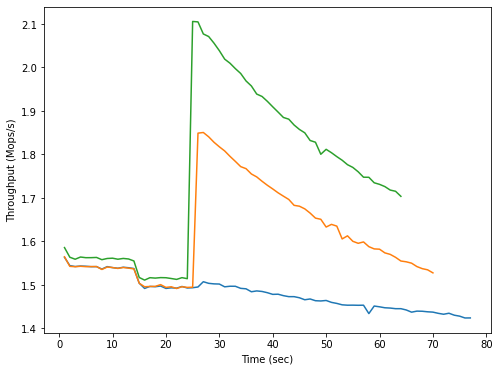

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="LearnedStore")
ax.plot(time_3, through_3, label="LearnedStore (fast insert)")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")

In [17]:
exp_1 = "../logs/ycsbb.log"
exp_2 = "../logs/ycsbbseg.log"
exp_3 = "../logs/ycsbbseg_fastinsert.log"

In [18]:
time_1, through_1 = get_results(exp_1)
time_2, through_2 = get_results(exp_2)
time_3, through_3 = get_results(exp_3)

/tmp/ipykernel_1088804/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1088804/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

Text(0, 0.5, 'Throughput (Mops/s)')

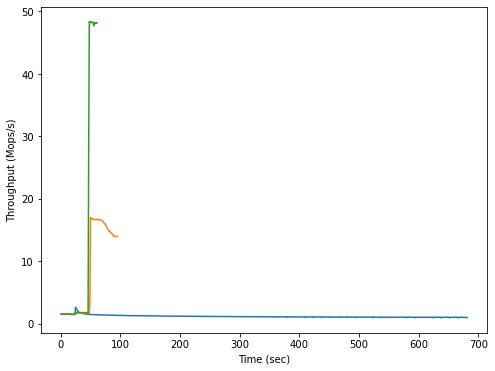

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="LearnedStore")
ax.plot(time_3, through_3, label="LearnedStore (fast insert)")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")

# YCSBA

In [28]:
exp1 = "../logs/ycsba.log"
exp2 = "../logs/ycsbaseg_fastinsert.log"
exp3 = "../logs/ycsbaseg.log"


In [29]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)
time_3, through_3 = get_results(exp3)

/tmp/ipykernel_1161582/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1161582/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

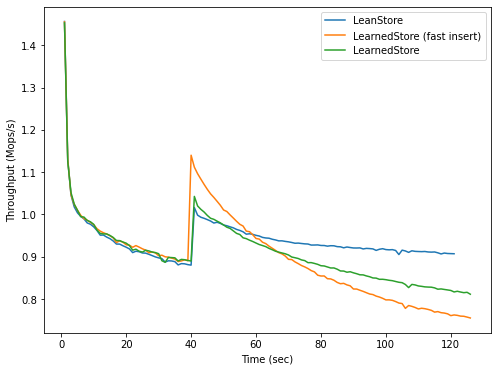

In [30]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="LearnedStore (fast insert)")
ax.plot(time_3, through_3, label="LearnedStore")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")
fig.savefig("../logs/ycsba_fastinsert_firstrandomload.png")

In [55]:
exp1 = "../logs/ycsba_loadsortedfirst.log"
exp2 = "../logs/ycsbaseg_loadsortedfirst.log"
exp3 = "../logs/ycsbaseg_fastinsert_loadsortedfirst.log"

In [56]:
time_1, through_1 = get_results(exp1)
time_2, through_2 = get_results(exp2)
time_3, through_3 = get_results(exp3)

/tmp/ipykernel_1161582/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1161582/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

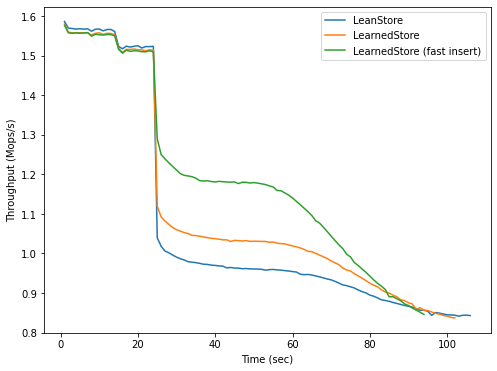

In [57]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, through_1, label="LeanStore")
ax.plot(time_2, through_2, label="LearnedStore")
ax.plot(time_3, through_3, label="LearnedStore (fast insert)")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")
fig.savefig("../logs/ycsba_loadsortedfirst.png")

# YCSBB

In [47]:
exp1 = "../logs/ycsbb.log"
exp2 = "../logs/ycsbbseg_fastinsert.log"
exp3 = "../logs/ycsbbseg.log"

In [48]:
time_1, throughput_1 = get_results(exp1)
time_2, throughput_2 = get_results(exp2)
time_3, throughput_3 = get_results(exp3)

/tmp/ipykernel_1161582/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1161582/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

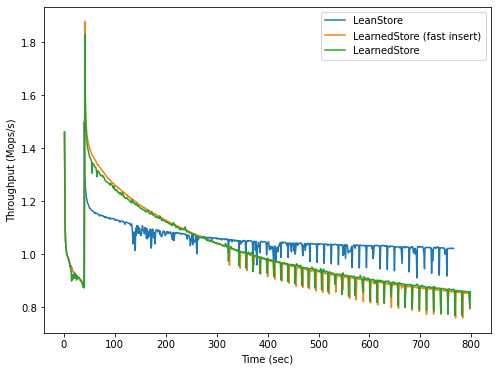

In [49]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, throughput_1, label="LeanStore")
ax.plot(time_2, throughput_2, label="LearnedStore (fast insert)")
ax.plot(time_3, throughput_3, label="LearnedStore")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")
fig.savefig("../logs/ycsbb_fastinsert_firstrandomload.png")

In [50]:
exp1 = "../logs/ycsbb_loadsortedfirst.log"
exp2 = "../logs/ycsbbseg_loadsortedfirst.log"
exp3 = "../logs/ycsbbseg_fastinsert_loadsortedfirst.log"

In [51]:
time_1, throughput_1 = get_results(exp1)
time_2, throughput_2 = get_results(exp2)
time_3, throughput_3 = get_results(exp3)

/tmp/ipykernel_1161582/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1161582/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

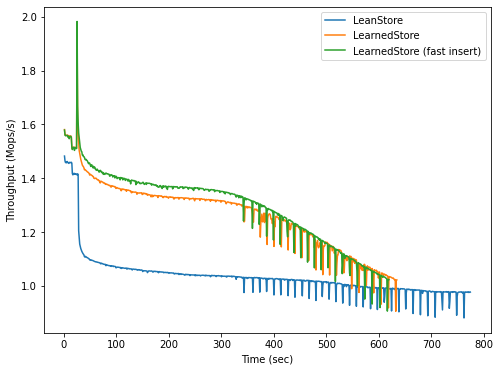

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, throughput_1, label="LeanStore")
ax.plot(time_2, throughput_2, label="LearnedStore")
ax.plot(time_3, throughput_3, label="LearnedStore (fast insert)")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")
fig.savefig("../logs/ycsbb_loadsortedfirst.png")

# Auto train

In [14]:
exp1 = "../logs/2insert.log"
exp2 = "../logs/2insert_auto_train.log"

In [15]:
time_1, throughput_1 = get_results(exp1)
time_2, throughput_2 = get_results(exp2)

/tmp/ipykernel_1367989/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_1367989/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

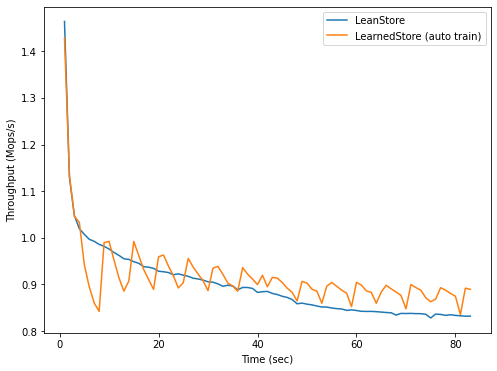

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, throughput_1, label="LeanStore")
ax.plot(time_2, throughput_2, label="LearnedStore (auto train)")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")
fig.savefig("../logs/2insert_auto_train.png")

In [44]:
exp1 = "../logs/ycsba_auto_train.log"
exp2 = "../logs/ycsbaseg_auto_train.log"

In [45]:
time_1, throughput_1 = get_results(exp1)
time_2, throughput_2 = get_results(exp2)

/tmp/ipykernel_2289952/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_2289952/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

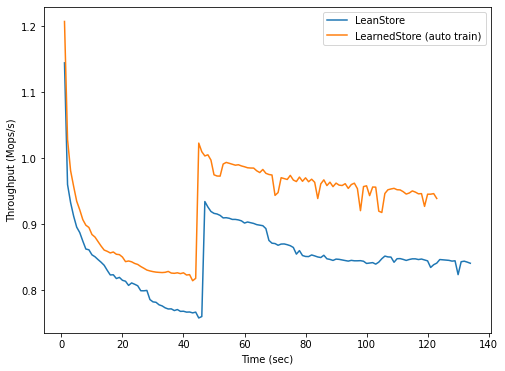

In [46]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, throughput_1, label="LeanStore")
ax.plot(time_2, throughput_2, label="LearnedStore (auto train)")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")
fig.savefig("../logs/ycsba_auto_train.png")

In [41]:
exp1 = "../logs/ycsbb_auto_train.log"
exp2 = "../logs/ycsbbseg_auto_train.log"

In [42]:
time_1, throughput_1 = get_results(exp1)
time_2, throughput_2 = get_results(exp2)

/tmp/ipykernel_2289952/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_2289952/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

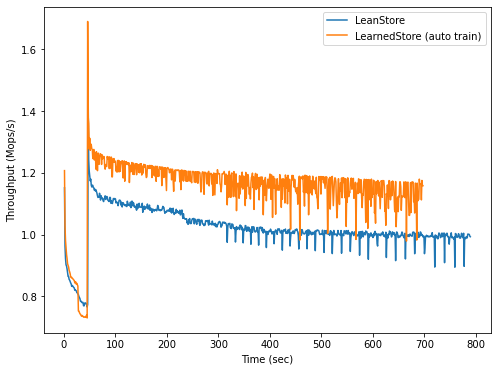

In [43]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, throughput_1, label="LeanStore")
ax.plot(time_2, throughput_2, label="LearnedStore (auto train)")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")
fig.savefig("../logs/ycsbb_auto_train.png")

# Insert and Fast Insert
Impact of height

In [13]:
exp1 = "../logs/leanstore_insert.log"
exp2 = "../logs/learnstore_insert_sth3.log"
exp3 = "../logs/learnstore_insert_sth4.log"
exp4 = "../logs/learnstore_insert_sth2.log"
exp5 = "../logs/learnstore_insert_sth3_usesth3.log"
exp6 = "../logs/learnstore_insert_sth3_use_10.log"

In [14]:
time_1, throughput_1 = get_results(exp1)
time_2, throughput_2 = get_results(exp2)
time_3, throughput_3 = get_results(exp3)
time_4, throughput_4 = get_results(exp4)
time_5, throughput_5 = get_results(exp5)

/tmp/ipykernel_2062073/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_2062073/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

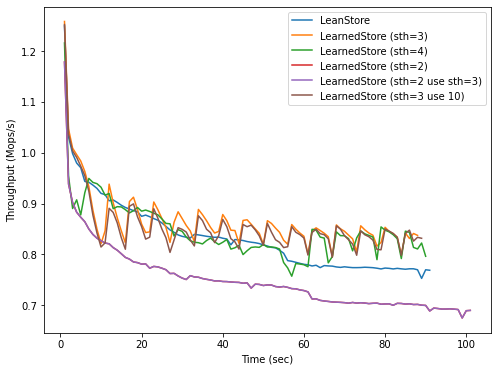

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, throughput_1, label="LeanStore")
ax.plot(time_2, throughput_2, label="LearnedStore (sth=3)")
ax.plot(time_3, throughput_3, label="LearnedStore (sth=4)")
ax.plot(time_4, throughput_4, label="LearnedStore (sth=2)")
ax.plot(time_4, throughput_4, label="LearnedStore (sth=2 use sth=3)")
ax.plot(time_5, throughput_5, label="LearnedStore (sth=3 use 10)")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")

In [48]:
exp1 = "../logs/leanstore_incorrecttol.log"
exp2 = "../logs/learnstore_incorrecttol.log"
exp3 = "../logs/learnstore_incorrecttol_nosleep.log"
exp4 = "../logs/learnstore_incorrecttol_wait.log"

In [49]:
time_1, throughput_1 = get_results(exp1)
time_2, throughput_2 = get_results(exp2)
time_3, throughput_3 = get_results(exp3)
time_4, throughput_4 = get_results(exp4)

/tmp/ipykernel_2062073/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_2062073/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

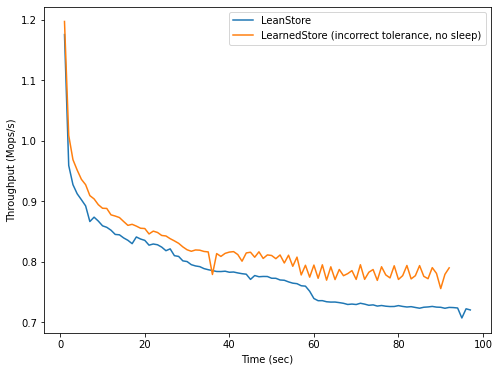

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, throughput_1, label="LeanStore")
# ax.plot(time_2, throughput_2, label="LearnedStore (incorrect tolerance)")
ax.plot(time_3, throughput_3, label="LearnedStore (incorrect tolerance, no sleep)")
# ax.plot(time_4, throughput_4, label="LearnedStore (incorrect tolerance, wait)")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")

In [38]:
exp1 = "../logs/leanstore_incorrecttol.log"
exp2 = "../logs/leanstore_incorrecttol_1.log"
exp3 = "../logs/leanstore_incorrecttol_1_5.log"
exp4 = "../logs/leanstore_incorrecttol_2.log"
exp5 = "../logs/leanstore_incorrecttol_8.log"
exp6 = "../logs/leanstore_incorrecttol_14.log"
exp7 = "../logs/leanstore_incorrecttol_16.log"

In [39]:
time_1, throughput_1 = get_results(exp1)
time_2, throughput_2 = get_results(exp2)
time_3, throughput_3 = get_results(exp3)
time_4, throughput_4 = get_results(exp4)
time_5, throughput_5 = get_results(exp5)
time_6, throughput_6 = get_results(exp6)
time_7, throughput_7 = get_results(exp7)

/tmp/ipykernel_2289952/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_2289952/499431022.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['threa

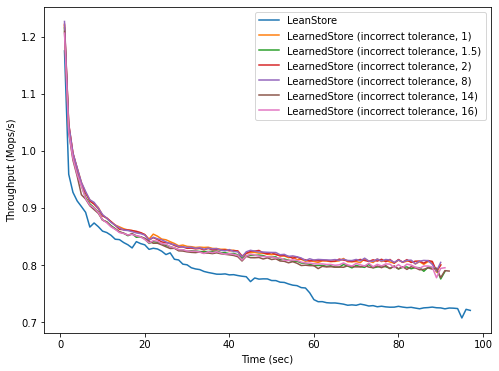

In [40]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time_1, throughput_1, label="LeanStore")
ax.plot(time_2, throughput_2, label="LearnedStore (incorrect tolerance, 1)")
ax.plot(time_3, throughput_3, label="LearnedStore (incorrect tolerance, 1.5)")
ax.plot(time_4, throughput_4, label="LearnedStore (incorrect tolerance, 2)")
ax.plot(time_5, throughput_5, label="LearnedStore (incorrect tolerance, 8)")
ax.plot(time_6, throughput_6, label="LearnedStore (incorrect tolerance, 14)")
ax.plot(time_7, throughput_7, label="LearnedStore (incorrect tolerance, 16)")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")

# Two insert tag


In [13]:
time1, throughput1 = get_results("../logs/write/leanstore.log")
time2, throughput2 = get_results("../logs/write/learnstore.log")

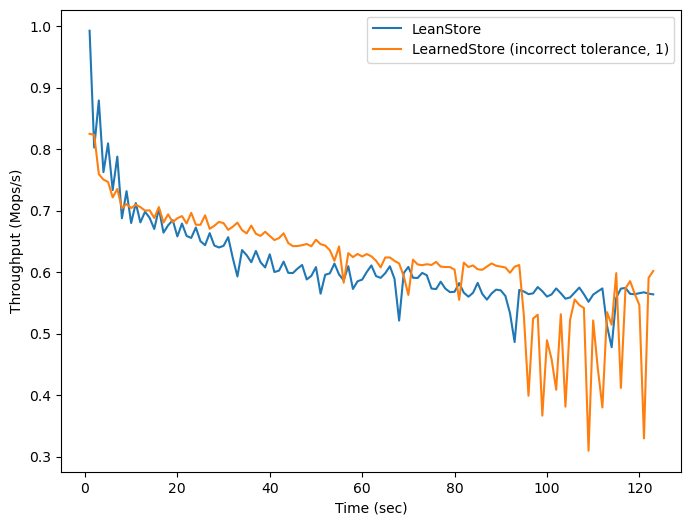

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(time1, throughput1, label="LeanStore")
ax.plot(time2, throughput2, label="LearnedStore (incorrect tolerance, 1)")
ax.set_xlabel("Time (sec)")
ax.set_ylabel("Throughput (Mops/s)")
ax.legend(loc="upper right")